In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

## Minimum Variance Portfolio Backtest.

In [2]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

(CVXPY) Jun 11 03:14:03 PM: Encountered unexpected exception importing solver PROXQP:
ImportError("dlopen(/Users/buchkovv/qamsi/.venv/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/proxsuite/proxsuite_pywrap.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/libc++.1.dylib\n  Referenced from: <73C5C23C-530A-3E0E-A88E-7897A0C69618> /Users/buchkovv/qamsi/.venv/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/proxsuite/proxsuite_pywrap.cpython-312-darwin.so\n  Reason: tried: '/Users/runner/miniconda3/envs/proxsuite/lib/libc++.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/miniconda3/envs/proxsuite/lib/libc++.1.dylib' (no such file), '/var/folders/0j/bwqcs4y508s2n4ck4dhf3rpc0000gn/T/cmeel-qko5evau/whl/cmeel.prefix/lib/libc++.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/var/folders/0j/bwqcs4y508s2n4ck4dhf3rpc0000gn/T/cmeel-qko5evau/whl/cmeel.prefix/lib/libc++.1.dylib' (no such file), '/Users

In [3]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [4]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.MIN_ROLLING_PERIODS = ESTIMATION_WINDOW + 1
experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2004-03-19 00:00:00 to 2023-12-29 00:00:00


In [5]:
ESTIMATOR = CovEstimators.QIS.value(k=1)

strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Num Train Iterations: 221


Computing Weights: 100%|██████████| 221/221 [00:26<00:00,  8.31it/s]


StrategyStatistics:
* final_nav = 6.139220
* geom_avg_total_r = 0.130557
* geom_avg_xs_r = 0.095516
* std_xs_r = 0.236419
* min_xs_r = -0.119049
* max_xs_r = 0.110338
* skew = -0.287608
* kurtosis = 10.769106
* max_dd = -0.622163
* sharpe = 0.404012
* alpha_buy_hold = 0.033267
* tracking_error_buy_hold = 0.054830
* ir_buy_hold = 0.606734
* factor_loadings = {'low_risk': -0.26766017669985803, 'momentum': 0.02543359117006647, 'quality': 0.011984175813787055, 'size': 0.10397515005834468, 'value': 0.36472251399998007, 'spx': 0.9447380865563744}
* alpha_benchmark = 0.033860
* alpha_benchmark_pvalue = 0.000709
* tracking_error_benchmark = 0.035146
* ir_benchmark = 0.963411
* ttest_pval = 0.343447
* levene_pval = 0.000630
* timing_ability_coef = -0.011152
* timing_ability_pval = 0.235721

In [6]:
result.std_xs_r

np.float64(0.23641923528926864)

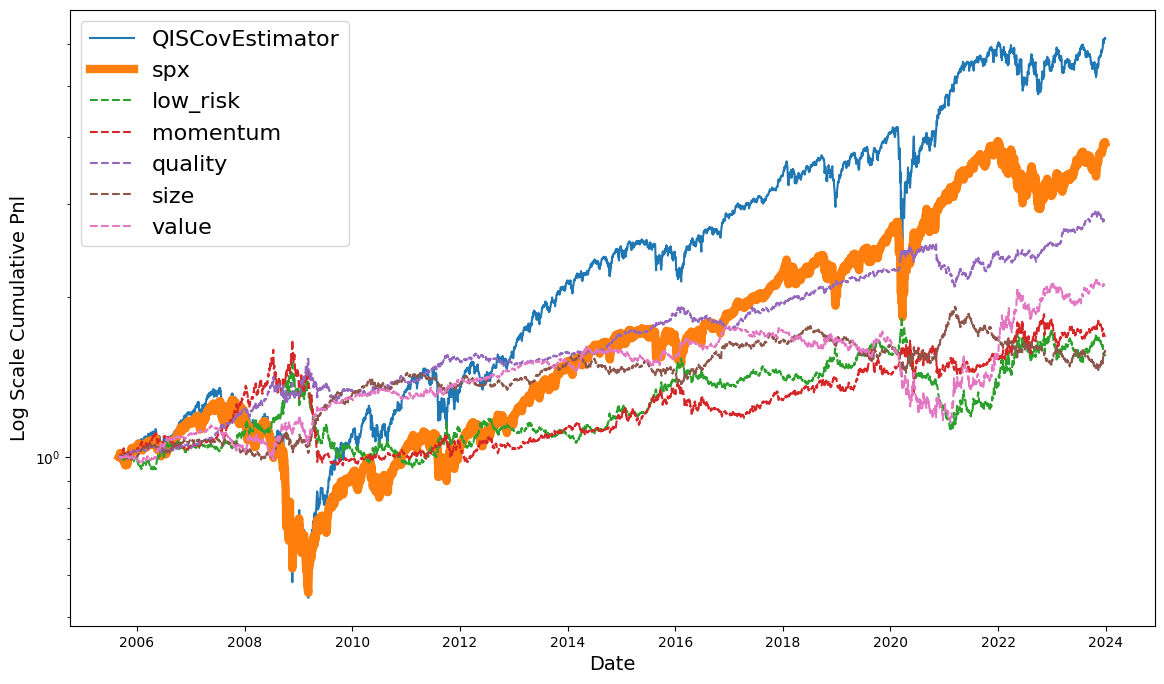

In [7]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

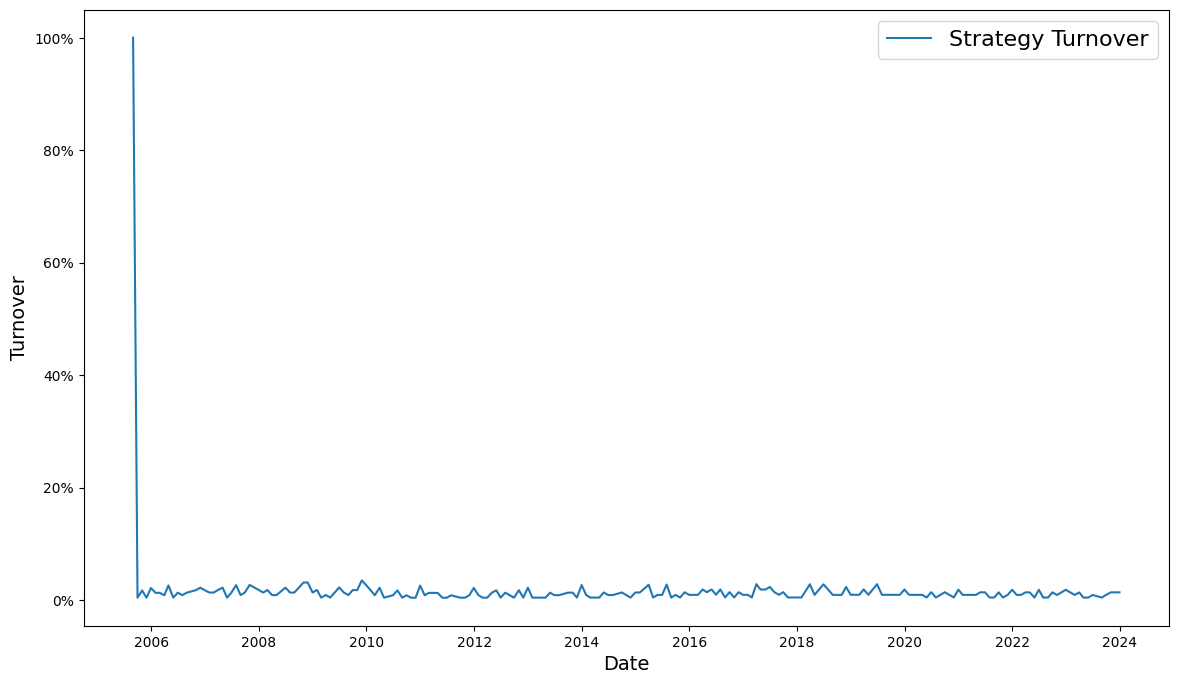

In [8]:
runner.plot_turnover()

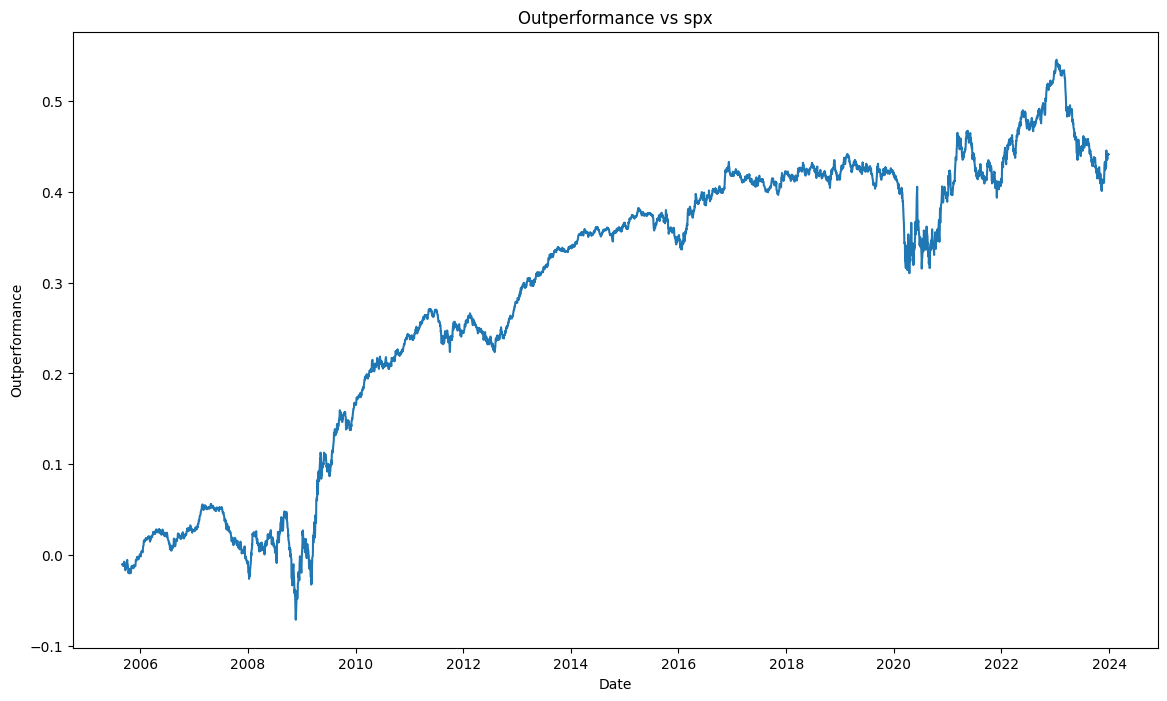

In [9]:
runner.plot_outperformance(mkt_only=True)

In [10]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")